# Sea Surface Height — NEMO GYRE

Analyse SSH (`sossheig`) from the GYRE simulation.
- Temporal variance (spatial map)
- Domain-mean SSH time series

In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import nc_time_axis  # noqa: F401 — registers cftime support in matplotlib

from gyre import load_output, load_mesh, interior_mask, cell_area, gyre_map

plt.rcParams.update({"font.size": 16, "axes.titlesize": 18, "axes.labelsize": 14})

OUTPUT_DIR = Path("../output")

## Load simulation output

Load the recombined grid_T file (SSH, SST, SSS) and the mesh_mask
(grid geometry and land/sea mask). Cell widths `e1t`/`e2t` from the
mesh_mask are used for area-weighted spatial averaging.

In [2]:
ds = load_output("*_grid_T.nc", OUTPUT_DIR)
mesh = load_mesh(OUTPUT_DIR)

interior = interior_mask(mesh.tmask.isel(nav_lev=0))
area = cell_area(mesh)

ssh = ds["sossheig"]
ssh

/gxfs_work/geomar/smomw122/2026-Claude-NEMO/analysis/gyre.py:48: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ds = xr.open_mfdataset(files, decode_cf=False, chunks=-1)


<xarray.DataArray 'sossheig' (time_counter: 2124, y: 102, x: 152)> Size: 132MB
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.01895508, -0.01750042, ...,  0.01174451,
          0.01654299,  0.        ],
        [ 0.        , -0.0178762 , -0.01415727, ...,  0.00071399,
          0.00899067,  0.        ],
        ...,
        [ 0.        , -0.01347346, -0.00862813, ..., -0.00441936,
          0.00577426,  0.        ],
        [ 0.        , -0.01599454, -0.01440169, ...,  0.00632278,
          0.01162595,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.05318177, -0.05058743, ..., -0.00396119,
          0.00138136,  0.        ],
        [ 0.        , -0.05011699, -0.04089449, ..., -0.01456131,
         -0.00483849,  0.        ],
...
         -0.09490283,  0.        ],
        [ 0.        ,  0.07152048,  0.08575163, ..., -0.09586245,
         -0.0855208 ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.01014844,  0.00173289, ..., -0.00583055,
         -0.0035738 ,  0.        ],
        [ 0.        ,  0.00253564, -0.01727067, ..., -0.01240768,
         -0.00667675,  0.        ],
        ...,
        [ 0.        ,  0.08891843,  0.1448751 , ..., -0.09955445,
         -0.06769466,  0.        ],
        [ 0.        ,  0.08605151,  0.10054127, ..., -0.06934787,
         -0.0567296 ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]],
      shape=(2124, 102, 152), dtype=float32)
Coordinates:
  * time_counter  (time_counter) float64 17kB 4.32e+05 1.296e+06 ... 1.835e+09
  * y             (y) int64 816B 0 1 2 3 4 5 6 7 8 ... 94 95 96 97 98 99 100 101
  * x             (x) int64 1kB 0 1 2 3 4 5 6 7 ... 145 146 147 148 149 150 151
Attributes:
    units:               m
    standard_name:       Sea Surface Height
    _FillValue:          9.96921e+36
    long_name:           Sea Surface Height
    online_operation:    ave(x)
    interval_operation:  2880.0
    interval_write:      864000.0
    coordinates:         time_counter nav_lat nav_lon

## SSH temporal variance

Variance over time at each grid point.

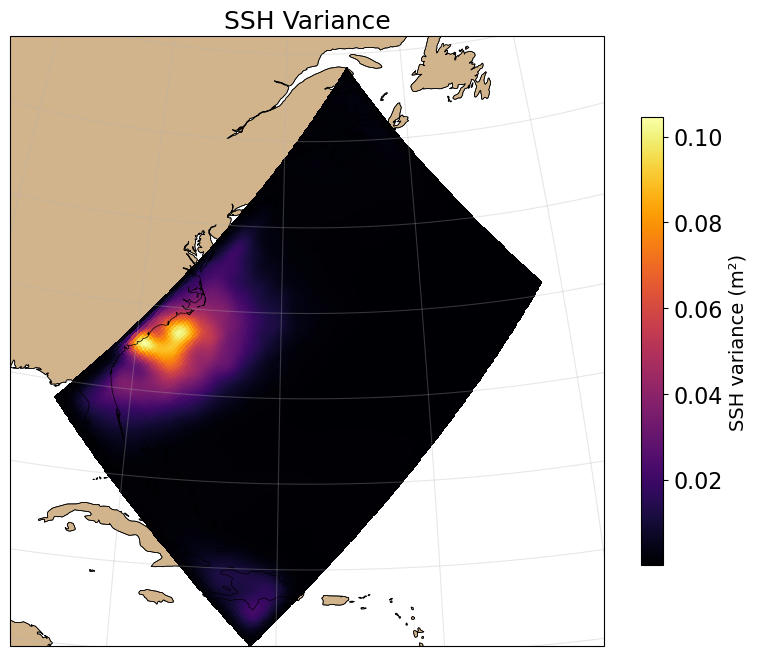

In [3]:
ssh_var = ssh.var("time_counter").where(interior)

fig, ax = gyre_map(ds=ds)

pcm = ax.pcolormesh(
    ds.nav_lon.values, ds.nav_lat.values, ssh_var.values,
    shading="auto", cmap="inferno", transform=ccrs.PlateCarree(),
)
fig.colorbar(pcm, ax=ax, label="SSH variance (m²)", shrink=0.7)
ax.set_title("SSH Variance")
fig.tight_layout()
fig.savefig("../figures/ssh_variance.png", dpi=150, bbox_inches="tight")

## Domain-mean SSH time series

Area-weighted SSH averaged over interior ocean points.

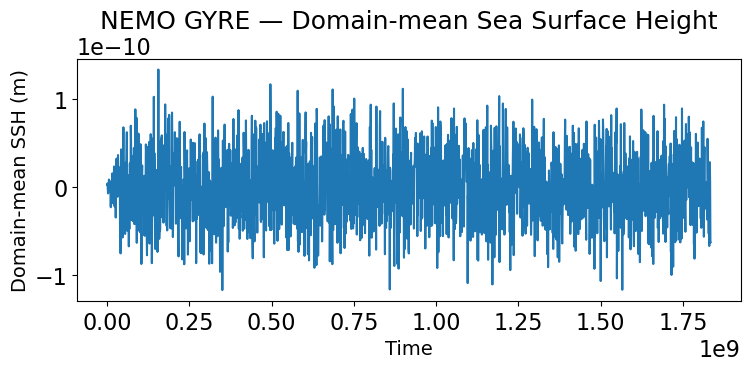

In [4]:
weights = area * interior
ssh_mean = ssh.weighted(weights).mean(["y", "x"])

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(ssh_mean.time_counter, ssh_mean)
ax.set_xlabel("Time")
ax.set_ylabel("Domain-mean SSH (m)")
ax.set_title("NEMO GYRE — Domain-mean Sea Surface Height")
fig.tight_layout()